In [1]:
# Import required packages/modules
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import sample
import math
from itertools import chain
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from sklearn.utils import shuffle

In [2]:
# Set working directory and import csv
# os.chdir("C:/Users/LynchZ20/Desktop/Courses/MSDS/SY_S2/ML/FinalProject/COVID19_DeepLearning/")
dd = pd.read_csv("final.csv")

In [3]:
# Look at summary info
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80843 entries, 0 to 80842
Columns: 187 entries, date to SAH
dtypes: float64(177), int64(3), object(7)
memory usage: 115.3+ MB


In [4]:
# Initialize dataframe and number of days to keep for RNN
trend_df = pd.DataFrame(columns={"cases_trend","deaths_trend", "SAH"})
trend_list = []
days_in_sequence = 20
reverse = True

# Churn through each county and create a row for each day with the previous 14 days of data
for county in dd.fips.unique():
    county_df = dd.query(f"fips=='{county}'")
            
    # Make strides of 1, and ignore padding on both ends at this point
    for i in range(0,len(county_df)):
        if i+days_in_sequence<=len(county_df):

            if reverse: # Grab the next X days for the model if we are reversing
                #Prepare list of cases and deaths
                cases_trend = [float(x) for x in county_df[-i-days_in_sequence:-1-i].cases.values]
                deaths_trend = [float(x) for x in county_df[-i-days_in_sequence:-1-i].deaths.values]

                #Add response value
                SAH = float(county_df.iloc[-i-days_in_sequence].SAH)
            else:
                cases_trend = [float(x) for x in county_df[i:i+days_in_sequence-1].cases.values]
                deaths_trend = [float(x) for x in county_df[i:i+days_in_sequence-1].deaths.values]
                SAH = float(county_df.iloc[i+days_in_sequence-1].SAH)

            trend_list.append({"cases_trend":np.asarray(cases_trend),
                                "deaths_trend":np.asarray(deaths_trend),
                                "SAH":SAH})
trend_df = pd.DataFrame(trend_list)

In [32]:
# Prepare RNN input
trend_df["inputs"] = [np.asarray([trends["cases_trend"],trends["deaths_trend"]]) for idx,trends in trend_df.iterrows()]
trend_df = shuffle(trend_df)

In [33]:
# Set up train/test split
sequence_length = days_in_sequence - 1
training_percentage = 0.7

# Perform train/test split
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [34]:
# Prepare train sets
X_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["inputs"].values]),(training_item_count,2,sequence_length)),(0,2,1) )).astype(np.float32)
Y_train = np.asarray([np.asarray(x) for x in training_df["SAH"]]).astype(np.float32)

# Prepare test sets
X_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["inputs"].values]),(validation_item_count,2,sequence_length)),(0,2,1) )).astype(np.float32)
Y_test = np.asarray([np.asarray(x) for x in validation_df["SAH"]]).astype(np.float32)

In [40]:
# design network
model = models.Sequential()
model.add(layers.LSTM(32, input_shape=(X_test.shape[1], X_train.shape[2]), return_sequences=True))
model.add(layers.LSTM(32, input_shape=(X_test.shape[1], X_train.shape[2])))
model.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=25,
                    validation_data=(X_test, Y_test)
                   )

Train on 21799 samples, validate on 9343 samples
Epoch 1/10
21799/21799 [==============================] - 11s 486us/sample - loss: 0.6045 - accuracy: 0.6627 - val_loss: 0.5835 - val_accuracy: 0.6822
Epoch 2/10
21799/21799 [==============================] - 9s 410us/sample - loss: 0.5882 - accuracy: 0.6749 - val_loss: 0.5809 - val_accuracy: 0.6819
Epoch 3/10
21799/21799 [==============================] - 9s 403us/sample - loss: 0.5835 - accuracy: 0.6817 - val_loss: 0.5804 - val_accuracy: 0.6865
Epoch 4/10
21799/21799 [==============================] - 10s 441us/sample - loss: 0.5827 - accuracy: 0.6770 - val_loss: 0.5836 - val_accuracy: 0.6730
Epoch 5/10
21799/21799 [==============================] - 9s 401us/sample - loss: 0.5805 - accuracy: 0.6787 - val_loss: 0.5820 - val_accuracy: 0.6825
Epoch 6/10
21799/21799 [==============================] - 9s 396us/sample - loss: 0.5794 - accuracy: 0.6834 - val_loss: 0.5775 - val_accuracy: 0.6830
Epoch 7/10
21799/21799 [=========================

In [43]:
sum(Y_test)/len(Y_test)

0.4052231617253559

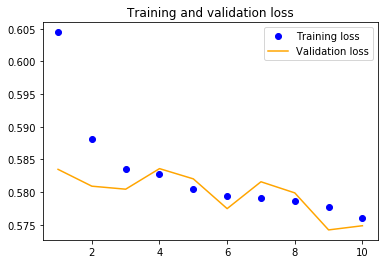

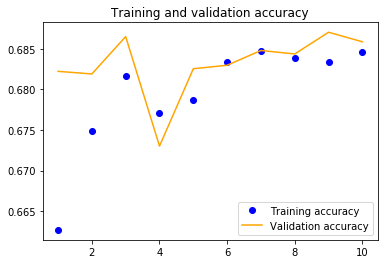

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()